# MAIN QUEST 01 Transformer GPT-1

# Transformer vs. GPT-1 변경점 요약

기존 Transformer 모델과 GPT-1 모델의 주요 차이점 및 코드 수정 방향은 다음과 같습니다:

1.  **아키텍처:**
    * Transformer: Encoder-Decoder 구조를 가집니다. 번역과 같은 Sequence-to-Sequence 작업에 주로 사용됩니다.
    * GPT-1: Decoder-only 구조를 가집니다. 주로 언어 모델링 및 생성 작업에 특화되어 있습니다.
    * **수정:** 제공된 코드는 이미 `gpt` 함수 내에서 Decoder 구조를 사용하고 있어, 아키텍처의 큰 변경은 필요하지 않습니다. 하지만 데이터 입력 파이프라인이 Seq2Seq 형태(input/target 쌍)가 아닌, 언어 모델링 형태(다음 토큰 예측)로 수정되어야 합니다.

2.  **입력 처리:**
    * Transformer: Encoder 입력과 Decoder 입력 (Teacher Forcing 시 이전 타겟 시퀀스)을 받습니다.
    * GPT-1 (Pre-training): 연속된 텍스트 시퀀스를 입력으로 받아 다음 토큰을 예측하는 언어 모델링 목표를 사용합니다.
    * **수정:** 기존 코드는 질문(Q)과 답변(A)을 별도로 토큰화하고, `inputs`와 `dec_inputs`를 데이터셋으로 구성했습니다. GPT-1 언어 모델 학습을 위해, 데이터를 단일 시퀀스로 처리하고, 입력 시퀀스 (`inputs`)와 타겟 시퀀스 (`outputs`, 입력 시퀀스를 한 칸 민 것)로 구성된 데이터셋으로 변경해야 합니다.

3.  **Attention Mask:**
    * Transformer: Encoder Self-Attention, Decoder Masked Self-Attention, Encoder-Decoder Attention 사용.
    * GPT-1: Masked Self-Attention (Look-ahead Mask)만 사용합니다.
    * **수정:** 제공된 코드의 `create_look_ahead_mask` 함수와 `MultiHeadAttention` 내 마스크 적용 로직은 GPT-1 방식과 호환됩니다.

4.  **Position Encoding:**
    * Transformer (Original): Sinusoidal (sine and cosine) 방식 사용.
    * GPT-1: 학습 가능한 Wording Embedding and Position Embedding 사용. 
    * **수정:** 제공된 코드는 이미 학습 가능한 Position Embedding (`tf.keras.layers.Embedding`)을 사용하고 있어, 수정이 필요 없음. 하지만 여기서, word embedding도 같이 사용. 따라서, 텍스트를 숫자로 변환 후 임베딩, 단어 위치 정보를 학습 가능한 벡터로 변환, 단어의미 + 위치정보를 더하여 최종 입력 벡터 생성.

5.  **Feed-Forward Network Activation:**
    * Transformer (Original): ReLU 사용.
    * GPT-1: GELU (Gaussian Error Linear Unit) 사용.
    * **수정:** `decoder_layer` 내의 Dense 레이어 활성화 함수를 ReLU에서 GELU로 변경해야 합니다.

6.  **데이터셋 구성 및 학습:**
    * **수정:** `tf.data.Dataset` 생성 부분을 수정하여, 모델이 예상하는 입력 형태 (`inputs`)와 타겟 (`outputs`)을 올바르게 제공해야 합니다. 현재 코드의 데이터셋 구조는 `ValueError: Missing data for input "input_1"` 오류의 원인입니다. 이를 언어 모델링에 맞게 `(입력 시퀀스, 타겟 시퀀스)` 튜플 형태로 수정합니다. (처음에 발생한 오류 부분 수정) 

In [13]:
# MAIN QUEST 01 Transformer GPT-1 (코드 시작)

import tensorflow as tf
import numpy as np
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import time # 시간 측정을 위해 추가
import tensorflow_datasets as tfds # 토크나이저를 위해 추가

print(tf.__version__)

2.6.0


## Step 1. Data Loads & Preprocessing & Utilize SubwordTextEncoder

1. 데이터 로드
한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다.

이 데이터는 아래의 링크에서 다운로드할 수 있습니다.

https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv

Cloud shell에서 아래 명령어를 입력해 주세요.

𝑚𝑘𝑑𝑖𝑟−𝑝 /𝑎𝑖𝑓𝑓𝑒𝑙/𝑡𝑟𝑎𝑛𝑠𝑓𝑜𝑟𝑚𝑒𝑟𝑐ℎ𝑎𝑡𝑏𝑜𝑡/𝑑𝑎𝑡𝑎/
ln -s ~/data/* ~/aiffel/transformer_chatbot/data/

2. 데이터 전처리
영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 
전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.

3. 단어 토큰화 과정 
한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다.
하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 
내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.

In [14]:
# 챗봇 데이터 로드
path = os.getenv('HOME') + '/aiffel/songys_chatbot/ChatbotData.csv'
data = pd.read_csv(path)

# 전처리 함수 (동일)
def preprocess_sentence(sentence):
    # ... (기존 코드와 동일)
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 한국어, 영어, 숫자, 주요 구두점, 공백 외 제거 (기존 코드와 동일)
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z?.!,1-9\s]", " ", sentence)
    sentence = sentence.strip()
    return sentence

# 질문, 답변 불러오기 (동일)
def load_conversations():
    inputs, outputs = [], []
    for idx, row in data.iterrows():
        q = row['Q']
        a = row['A']
        # 질문이나 답변이 문자열이 아닌 경우 건너뛰기 (데이터 오류 방지)
        if isinstance(q, str) and isinstance(a, str):
            inputs.append(preprocess_sentence(q))
            outputs.append(preprocess_sentence(a))
        elif isinstance(q, str): # 답변이 없거나 잘못된 경우 질문만 사용
             inputs.append(preprocess_sentence(q))
        elif isinstance(a, str): # 질문이 없거나 잘못된 경우 답변만 사용 (이 경우는 거의 없지만 안전하게)
             outputs.append(preprocess_sentence(a))
    return inputs, outputs


questions, answers = load_conversations()
print(f"총 질문 수: {len(questions)}")
print(f"총 답변 수: {len(answers)}")
print("전처리 후 샘플 질문:", questions[0])
print("전처리 후 샘플 답변:", answers[0])


# 토크나이저 빌드 (질문과 답변 모두 사용)
# SubwordTextEncoder
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
VOCAB_SIZE = tokenizer.vocab_size + 2

print(f"START_TOKEN: {START_TOKEN}")
print(f"END_TOKEN: {END_TOKEN}")
print(f"VOCAB_SIZE: {VOCAB_SIZE}")


# 최대 문장 길이 (동일)
MAX_LENGTH = 40

# 정수 인코딩 + 패딩 (질문 데이터만 사용하도록 수정)
# 함수 이름은 유지하되, 내부 로직 변경 (GPT 언어 모델링에 맞게 질문만 처리)
def tokenize_and_filter(inputs):
    tokenized_inputs = []
    for sentence in inputs:
        # 시작 토큰과 종료 토큰 추가
        sentence = START_TOKEN + tokenizer.encode(sentence) + END_TOKEN
        # 최대 길이 이하인 경우만 list에 추가
        if len(sentence) <= MAX_LENGTH:
            tokenized_inputs.append(sentence)

    # 패딩 처리
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs

# 질문 데이터만 토큰화 및 필터링
questions_tokenized = tokenize_and_filter(questions)
print("Tokenized questions shape:", questions_tokenized.shape)


# 데이터셋 준비 (GPT 언어 모델링 방식)
BATCH_SIZE = 64
BUFFER_SIZE = 20000 # 데이터가 작으므로 BUFFER_SIZE 조정 가능

# 입력: questions_tokenized의 마지막 토큰 제외 [:, :-1]
# 타겟: questions_tokenized의 첫 토큰 제외 [:, 1:]
dataset = tf.data.Dataset.from_tensor_slices((
    questions_tokenized[:, :-1], # 입력 시퀀스
    questions_tokenized[:, 1:]  # 타겟 시퀀스 (입력을 한 스텝 민 것)
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 데이터셋 구조 확인 (하나의 배치 샘플 출력)
for inputs, targets in dataset.take(1):
    print("Dataset Input shape:", inputs.shape)      # (BATCH_SIZE, MAX_LENGTH - 1)
    print("Dataset Target shape:", targets.shape)    # (BATCH_SIZE, MAX_LENGTH - 1)
    print("Sample Input:", inputs[0])
    print("Sample Target:", targets[0])

총 질문 수: 11823
총 답변 수: 11823
전처리 후 샘플 질문: 12시 땡 !
전처리 후 샘플 답변: 하루가 또 가네요 .
START_TOKEN: [8168]
END_TOKEN: [8169]
VOCAB_SIZE: 8170
Tokenized questions shape: (11823, 40)
Dataset Input shape: (64, 39)
Dataset Target shape: (64, 39)
Sample Input: tf.Tensor(
[8168 2078   80  541  148 3475 8169    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int32)
Sample Target: tf.Tensor(
[2078   80  541  148 3475 8169    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int32)


*목차*
1. Padding Mask
2. Look Ahead Masking
3. Multi Head Attention
4. Decoding Layer & Decoder
5. GPT Model define (word embedding + positional embedding)
위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.

## Step 2. Masking Functions

In [15]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x) # 입력 자체에 대한 패딩 마스크 생성
    return tf.maximum(look_ahead_mask, padding_mask)

## Step 3. Multi-Head Attention 

In [16]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % num_heads == 0
        self.depth = d_model // num_heads

        self.query_dense = tf.keras.layers.Dense(d_model)
        self.key_dense = tf.keras.layers.Dense(d_model)
        self.value_dense = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        matmul_qk = tf.matmul(query, key, transpose_b=True)
        dk = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        scaled_attention = tf.matmul(attention_weights, value)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        output = self.dense(concat_attention)
        return output

## Step 4. Decoder Layer (GPT-1)
reference: Radford, A., & Narasimhan, K. (2018). Improving Language Understanding by Generative Pre-Training.

In [17]:
# Step 4. Decoder Layer 수정 (name 인자 추가)
def decoder_layer(units, d_model, num_heads, dropout_rate, name="decoder_layer"): # name 인자 추가
    inputs = tf.keras.Input(shape=(None, d_model), name="layer_inputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="layer_look_ahead_mask")

    # Masked Multi-Head Self-Attention (첫 번째 서브층)
    # MultiHeadAttention 레이어 이름도 고유하게 설정 (선택 사항)
    attention_layer = MultiHeadAttention(d_model, num_heads) # 이름 중복 피하기 위해 인스턴스 생성
    attention = attention_layer(inputs={
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': look_ahead_mask # Look-ahead mask 적용
    })
    attention = tf.keras.layers.Dropout(dropout_rate)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + inputs) # Add & Norm

    # Position-wise Feed-Forward Network (두 번째 서브층)
    # 활성화 함수를 'relu' -> 'gelu'로 변경
    outputs = tf.keras.layers.Dense(units, activation='gelu')(attention)
    outputs = tf.keras.layers.Dense(d_model)(outputs)
    outputs = tf.keras.layers.Dropout(dropout_rate)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention) # Add & Norm

    # Model 생성 시 name 전달
    return tf.keras.Model(inputs=[inputs, look_ahead_mask], outputs=outputs, name=name)


## Step 5. To define GPT model 
1. 텍스트를 숫자로 변환 후 임베딩
2. 단어 위치 정보를 학습 가능한 벡터로 변환
3. 단어의미 + 위치정보를 더하여 최종 입력 벡터 생성

In [18]:
# Step 5. GPT 모델 정의 수정 (decoder_layer 호출 시 고유 이름 전달)
def gpt(vocab_size, num_layers, units, d_model, num_heads, dropout_rate, maximum_position_encoding):
    inputs = tf.keras.Input(shape=(None,), name='inputs')

    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(inputs)

    token_embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs) #Word Embedding

    seq_len = tf.shape(inputs)[1]
    positions = tf.range(start=0, limit=seq_len, delta=1) #Position Embedding
    position_embeddings = tf.keras.layers.Embedding(maximum_position_encoding, d_model)(positions) #Position Embedding
    position_embeddings = tf.expand_dims(position_embeddings, 0) #Position Embedding
                                                                

    embeddings = token_embeddings + position_embeddings #Word Embedding + Position Embedding
    embeddings = tf.keras.layers.Dropout(dropout_rate)(embeddings)

    x = embeddings
    for i in range(num_layers):
        # decoder_layer 호출 시 고유한 이름(f"decoder_layer_{i}") 전달
        x = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout_rate=dropout_rate,
            name=f"decoder_layer_{i}" # 고유 이름 전달
        )([x, look_ahead_mask])

    outputs = tf.keras.layers.Dense(vocab_size, name='outputs')(x)

    # Model 생성 시 inputs와 outputs가 Tensor여야 함
    return tf.keras.Model(inputs=inputs, outputs=outputs, name='GPT')


## Step 6. Loss Functions and Model Compile

In [19]:
# Step 6. Loss Functions and Model Compile (수정 없음 - 단, 모델 생성 시 파라미터 확인)

# CustomSchedule, loss_function, accuracy 함수는 기존 코드와 동일
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    # ... (기존 코드와 동일)
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32) # step을 float32로 변환
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

def loss_function(y_true, y_pred):
    # y_true shape: (batch_size, seq_len - 1)
    # y_pred shape: (batch_size, seq_len - 1, vocab_size)
    # 패딩된 부분(0)은 손실 계산에서 제외하기 위한 마스크 생성
    mask = tf.cast(tf.math.not_equal(y_true, 0), tf.float32)

    # SparseCategoricalCrossentropy 사용 (from_logits=True)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    # 마스크 적용
    loss = tf.multiply(loss, mask)

    # 배치 내 평균 손실 계산 (마스크된 부분 제외하고 평균)
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)
    # return tf.reduce_mean(loss) # 기존 방식: 패딩 고려 안 된 평균일 수 있음

def accuracy(y_true, y_pred):
    # y_true shape: (batch_size, seq_len - 1)
    # y_pred shape: (batch_size, seq_len - 1, vocab_size)
    # 가장 확률 높은 토큰 예측
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    # 예측과 실제값이 같은지 확인
    match = tf.cast(tf.equal(y_true, y_pred), tf.float32)

    # 패딩 마스크 생성
    mask = tf.cast(tf.math.not_equal(y_true, 0), tf.float32)

    # 마스크 적용
    match = tf.multiply(match, mask)

    # 정확도 계산 (마스크된 부분 제외하고 평균)
    return tf.reduce_sum(match) / tf.reduce_sum(mask)
    # return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred) # 기존 방식: 패딩 고려 안 된 정확도


# 하이퍼파라미터 (GPT-1 논문과 다름, 실험용으로 작은 값 유지)
NUM_LAYERS = 2 
D_MODEL = 256  
NUM_HEADS = 8  
UNITS = 512    
DROPOUT_RATE = 0.1

# 모델 생성
# maximum_position_encoding은 패딩 포함 최대 길이 MAX_LENGTH 사용
model = gpt(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout_rate=DROPOUT_RATE,
    maximum_position_encoding=MAX_LENGTH) # Positional Encoding 최대 길이

# 옵티마이저 및 컴파일 (Learning Rate Schedule은 Transformer 논문 방식 유지)
# GPT-1 논문은 cosine schedule 사용 [cite: 96]
learning_rate = CustomSchedule(d_model=D_MODEL)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

# 모델 요약 출력 (평가 기준 9)
model.summary()

Model: "GPT"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
tf.compat.v1.shape_1 (TFOpLambd (2,)                 0           inputs[0][0]                     
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli ()                   0           tf.compat.v1.shape_1[0][0]       
__________________________________________________________________________________________________
tf.range_1 (TFOpLambda)         (None,)              0           tf.__operators__.getitem_1[0][0] 
________________________________________________________________________________________________

## Step 7. Training 


--- Start Training for 20 epochs ---
Epoch 1/20
185/185 [==============================] - 10s 35ms/step - loss: 8.6161 - accuracy: 0.0992
Epoch 2/20
185/185 [==============================] - 6s 35ms/step - loss: 7.3494 - accuracy: 0.1543
Epoch 3/20
185/185 [==============================] - 6s 35ms/step - loss: 6.6402 - accuracy: 0.1610
Epoch 4/20
185/185 [==============================] - 7s 35ms/step - loss: 6.2858 - accuracy: 0.1746
Epoch 5/20
185/185 [==============================] - 7s 35ms/step - loss: 5.9959 - accuracy: 0.1931
Epoch 6/20
185/185 [==============================] - 7s 36ms/step - loss: 5.6992 - accuracy: 0.2100
Epoch 7/20
185/185 [==============================] - 7s 36ms/step - loss: 5.3880 - accuracy: 0.2279
Epoch 8/20
185/185 [==============================] - 7s 36ms/step - loss: 5.0568 - accuracy: 0.2524
Epoch 9/20
185/185 [==============================] - 7s 36ms/step - loss: 4.7081 - accuracy: 0.2817
Epoch 10/20
185/185 [==============================]

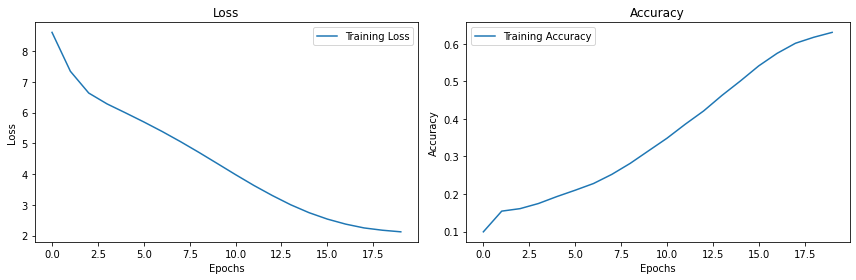

In [20]:
# --- Step 7. Training ---
EPOCHS = 20 #  epoch 20번 실행 하기
print(f"\n--- Start Training for {EPOCHS} epochs ---")

start_time = time.time()
history = model.fit(dataset, epochs=EPOCHS)
end_time = time.time()

print(f"\nTotal training time for {EPOCHS} epochs: {end_time - start_time:.2f} seconds")

# 학습 결과 시각화
if history and history.history:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("학습 기록이 없습니다.")


## Step 8. To Predict What's Coming on the Next? 

In [24]:
# --- Step 8. Prediction
def predict_next_token(sentence):
    print(f"\n--- Predicting for: '{sentence}' ---")
    if not sentence: return "입력 문장이 비어있습니다.", -1

    # 1. 전처리 및 토큰화
    sentence = preprocess_sentence(sentence)
    tokenized_sentence = START_TOKEN + tokenizer.encode(sentence)
    print(f"1. Tokenized input: {tokenized_sentence}")

    # 입력 길이 제한
    if len(tokenized_sentence) >= MAX_LENGTH:
         tokenized_sentence = tokenized_sentence[:MAX_LENGTH-1]
         print(f"   (Input truncated to {len(tokenized_sentence)} tokens)")

    # 2. 모델 입력 형태로 변환 및 패딩
    encoder_input = tf.expand_dims(tokenized_sentence, 0)
    padded_input = tf.keras.preprocessing.sequence.pad_sequences(
        encoder_input, maxlen=MAX_LENGTH - 1, padding='post'
    )
    print(f"2. Padded input shape: {padded_input.shape}")

    # 3. 모델 예측
    try:
        predictions = model(padded_input, training=False)
        print(f"3. Prediction output shape: {predictions.shape}")
    except Exception as e:
        print(f"!!! Model prediction failed: {e}")
        return "모델 예측 중 오류 발생", -1

    # 4. 마지막 타임스텝의 로짓 가져오기
    last_token_index = tf.shape(encoder_input)[1].numpy() - 1
    if last_token_index < 0: last_token_index = 0
    print(f"4. Last real token index: {last_token_index}")

    pred_seq_len = tf.shape(predictions)[1]
    if last_token_index >= pred_seq_len:
        print(f"   Warning: last_token_index ({last_token_index}) >= pred_seq_len ({pred_seq_len}). Adjusting index.")
        last_token_index = pred_seq_len - 1

    last_token_logits = predictions[0, last_token_index, :]
    print(f"   Logits shape for last token: {last_token_logits.shape}")

    # 5. 가장 확률 높은 토큰 ID 찾기 + Top 5 확인
    predicted_token_id = tf.argmax(last_token_logits).numpy()
    print(f"5. Predicted token ID (argmax): {predicted_token_id}")

    probabilities = tf.nn.softmax(last_token_logits).numpy()
    top_k_indices = np.argsort(probabilities)[-5:][::-1]
    top_k_probs = probabilities[top_k_indices]

    print("   Top 5 predictions:")
    for i in range(len(top_k_indices)):
        current_id = top_k_indices[i]
        # START_TOKEN 또는 END_TOKEN ID인지 확인 후 디코딩
        if current_id == START_TOKEN[0]:
            token_word = "<START>"
        elif current_id == END_TOKEN[0]:
            token_word = "<END>"
        elif current_id < tokenizer.vocab_size: # 유효한 범위 내 ID만 decode 호출
             try:
                 token_word = tokenizer.decode([current_id])
             except ValueError:
                 token_word = "<DECODE_ERROR>" # 혹시 모를 다른 decode 오류 대비
        else:
            token_word = "<INVALID_ID>" # 범위 밖 ID 처리

        print(f"     - Rank {i+1}: ID={current_id}, Prob={top_k_probs[i]:.4f}, Token='{token_word}'")

    # 6. 최종 예측된 토큰 ID -> 단어 변환 (Special Token 처리 포함)
    if predicted_token_id == START_TOKEN[0]:
        predicted_token = "<START>"
    elif predicted_token_id == END_TOKEN[0]:
        predicted_token = "<END>"
    elif predicted_token_id < tokenizer.vocab_size:
        try:
            predicted_token = tokenizer.decode([predicted_token_id])
        except ValueError:
             predicted_token = "<DECODE_ERROR>"
    else:
         predicted_token = "<INVALID_ID>"

    print(f"6. Decoded token (argmax result): '{predicted_token}'")

    return predicted_token, int(predicted_token_id) # ID는 정수형으로 반환

# 예측 테스트 (수정된 함수 사용)
print("\n--- Prediction Test ---")
test_sentences = ["오늘 날씨 어때", "영화 추천해줘", "배고파", "안녕"]
for sent in test_sentences:
    pred_word, pred_id = predict_next_token(sent)
    print(f"  -> 최종 예측 다음 단어: '{pred_word}' (ID: {pred_id})")

print("\n--- 코드 실행 완료 ---")


--- Prediction Test ---

--- Predicting for: '오늘 날씨 어때' ---
1. Tokenized input: [8168, 76, 1264, 376]
2. Padded input shape: (1, 39)
3. Prediction output shape: (1, 39, 8170)
4. Last real token index: 3
   Logits shape for last token: (8170,)
5. Predicted token ID (argmax): 2
   Top 5 predictions:
     - Rank 1: ID=2, Prob=0.9798, Token=' ?'
     - Rank 2: ID=8169, Prob=0.0197, Token='<END>'
     - Rank 3: ID=174, Prob=0.0002, Token='서'
     - Rank 4: ID=342, Prob=0.0001, Token='만'
     - Rank 5: ID=1056, Prob=0.0000, Token='가지'
6. Decoded token (argmax result): ' ?'
  -> 최종 예측 다음 단어: ' ?' (ID: 2)

--- Predicting for: '영화 추천해줘' ---
1. Tokenized input: [8168, 953, 3900]
2. Padded input shape: (1, 39)
3. Prediction output shape: (1, 39, 8170)
4. Last real token index: 2
   Logits shape for last token: (8170,)
5. Predicted token ID (argmax): 8169
   Top 5 predictions:
     - Rank 1: ID=8169, Prob=0.9361, Token='<END>'
     - Rank 2: ID=1, Prob=0.0593, Token=' .'
     - Rank 3: ID=205, Pr